# Getting The annotations From Segmentations


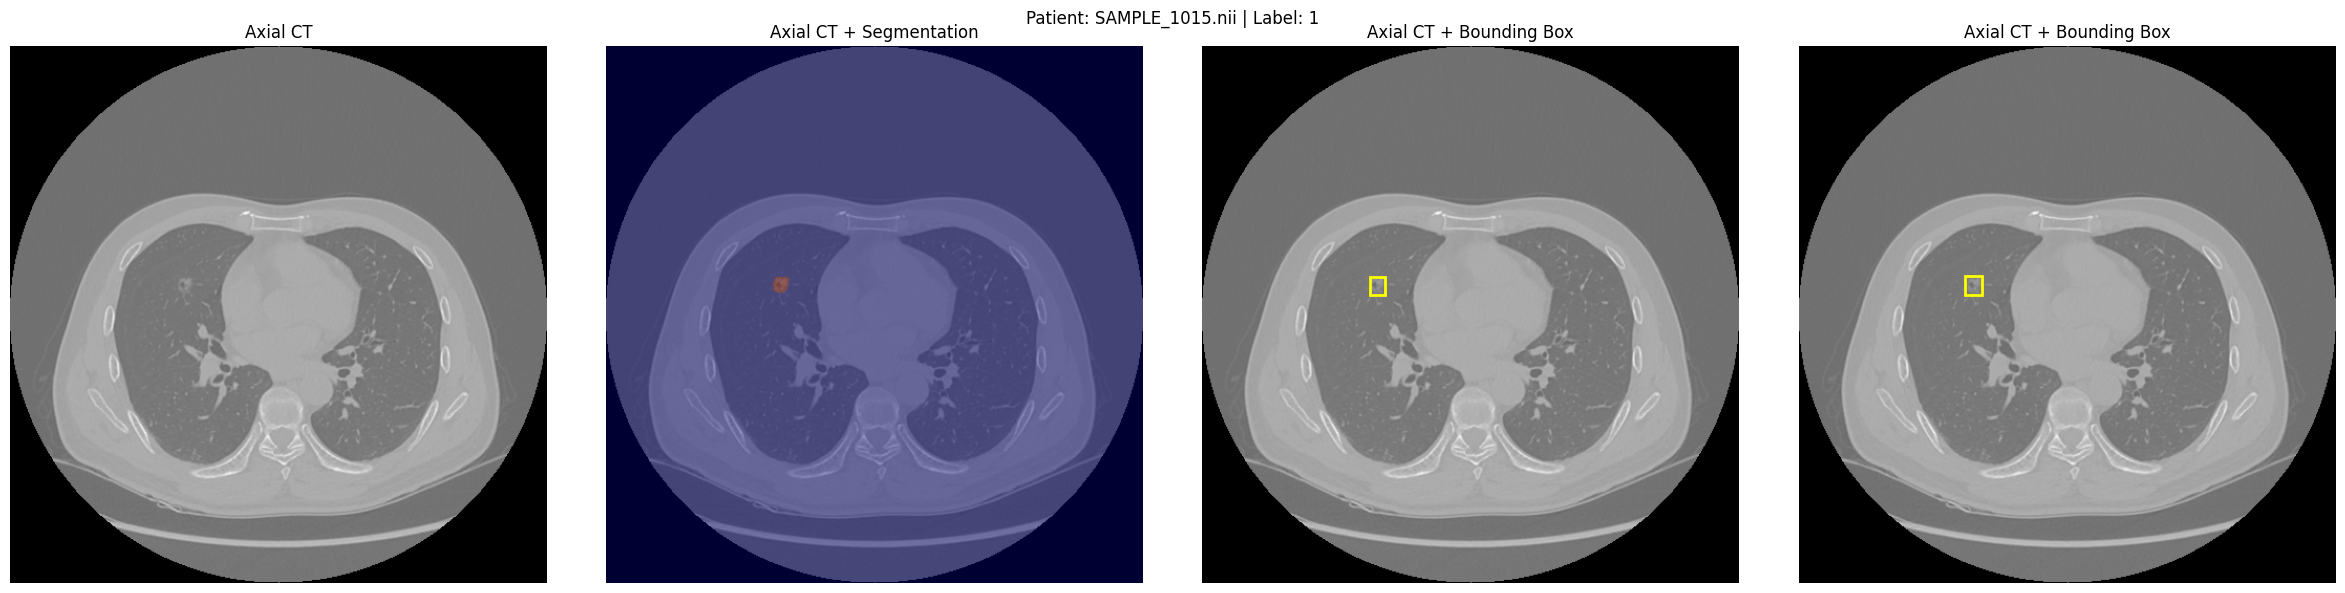

In [1]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Prepare CSV storage
bounding_boxes = []
error   = []

# Parent folder
parent_folder_ct  = '/NAS/shared_data/for_VNLST/ft42/ct_public/Intgmultiomics/Intgmultiomics_ct_nifti'
parent_folder_seg = '/NAS/shared_data/for_VNLST/ft42/ct_public/Intgmultiomics/Intgmultiomics_seg_nifti'
ct_fileNames      = [f for f in os.listdir(parent_folder_ct) if f.endswith('.nii')]


# Running an single sample as an example to show
for ct_fileName in ct_fileNames[0:1]:
    
    try:

        seg_filename = ct_fileName.split('.nii')[0]+'_seg.nii.gz'
        ct_path = os.path.join(parent_folder_ct, ct_fileName)
        seg_path = os.path.join(parent_folder_seg, seg_filename)

        if not os.path.exists(seg_path):
            print(f"No segmentation file in {ct_fileName}")
            continue

        # Load images
        ct_image  = sitk.ReadImage(ct_path)
        seg_image = sitk.ReadImage(seg_path)
        ct_array  = sitk.GetArrayFromImage(ct_image)
        seg_array = sitk.GetArrayFromImage(seg_image)

        spacing   = np.array(seg_image.GetSpacing())  # (x, y, z)
        origin    = np.array(seg_image.GetOrigin())
        direction = np.array(seg_image.GetDirection()).reshape(3, 3)

        # NEW: Handle multiple labels inside segmentation
        unique_labels = np.unique(seg_array)
        unique_labels = unique_labels[unique_labels != 0]  # skip background

        for label in unique_labels:
            indices = np.argwhere(seg_array == label)
            if indices.size == 0:
                print(f"No label-{label} found in {ct_fileName}")
                continue

            min_z, min_y, min_x = indices.min(axis=0)
            max_z, max_y, max_x = indices.max(axis=0)

            center_voxel = np.asarray([int((min_x + max_x) / 2), int((min_y + max_y) / 2), int((min_z + max_z) / 2)])
            size_voxel   = np.array([max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1])

            center_world = ct_image.TransformIndexToPhysicalPoint(center_voxel.tolist())
            size_mm      = size_voxel * spacing[[0, 1, 2]]

            center_voxel2 = ct_image.TransformPhysicalPointToIndex(center_world)
            size          = size_mm // spacing[[0, 1, 2]]

            patient_name = os.path.basename(ct_fileName)
            bounding_boxes.append({
                'SAMPLE_ID': patient_name.split('.nii')[0],
                'ct_path': os.path.join(*ct_path.split('/')[-2:]),
                'seg_path':os.path.join(*seg_path.split('/')[-2:]),
                'coordX': center_world[0],
                'coordY': center_world[1],
                'coordZ': center_world[2],
                'w'     : size_mm[0],
                'h'     : size_mm[1],
                'd'     : size_mm[2],
            })

            # Prepare axial slice
            z_idx     = int(center_voxel[2])
            axial_ct  = ct_array[z_idx, :, :]
            axial_seg = (seg_array[z_idx, :, :] == label).astype(int)  # only this label

            axial_ct2 = ct_array[center_voxel2[2], :, :]

            # Plot 1-row 3-column
            fig, axes = plt.subplots(1, 4, figsize=(24, 6))
            fig.suptitle(f"Patient: {patient_name} | Label: {label}")

            # 1️⃣ CT only
            axes[0].imshow(axial_ct, cmap='gray')
            axes[0].set_title('Axial CT')
            axes[0].axis('off')

            # 2️⃣ CT + segmentation overlay
            axes[1].imshow(axial_ct, cmap='gray')
            axes[1].imshow(axial_seg, cmap='jet', alpha=0.4)
            axes[1].set_title('Axial CT + Segmentation')
            axes[1].axis('off')

            # 3️⃣ CT + bounding box
            axes[2].imshow(axial_ct, cmap='gray')
            rect_x = min_x
            rect_y = min_y
            rect_w = max_x - min_x
            rect_h = max_y - min_y
            axes[2].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
            axes[2].set_title('Axial CT + Bounding Box')
            axes[2].axis('off')

            axes[3].imshow(axial_ct, cmap='gray')
            rect_x = int(center_voxel2[0] - size[0] // 2)
            rect_y = int(center_voxel2[1] - size[1] // 2)
            rect_w = size[0]
            rect_h = size[1]
            axes[3].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
            axes[3].set_title('Axial CT + Bounding Box')
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

    except:
        error_dict ={'patient':patient_name.split('.nii')[0],'ct_path':os.path.join(*ct_path.split('/')[-2:])}
        error.append(error_dict)
        

# Save bounding boxes to CSV
#df         = pd.DataFrame(bounding_boxes)
#output_csv = 'Intgmultiomics_bounding_boxes_annotations.csv'
#df.to_csv(output_csv, index=False)
#print(f"Saved bounding box CSV to: {output_csv}")


# Rechecking

|------------------------------ No=100 ------------------------------|


Loading the Image:SAMPLE_0595
Number of Annotations:1
Label...|1


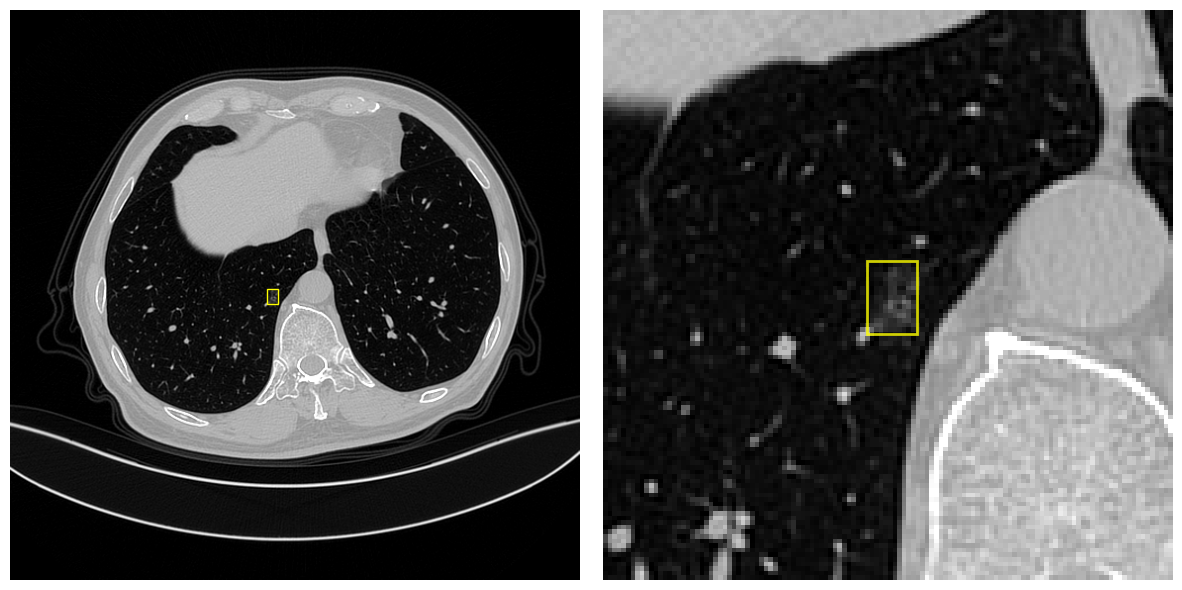

In [4]:
#-| Import libraries

import numpy as np
import SimpleITK as sitk
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math 
import pandas as pd
import numpy.ma as ma

##################################---Functions-------------#######################

def make_bold(text):
    return f"\033[1m{text}\033[0m"

#-| this function load an image using simpleITK and return 
#-|3D array, origin_numpy and spacing numpy
def load_itk_image(filename):
    '''
    this function load an image using simpleITK and return
    3D array, origin_numpy and spacing numpy
    input:  filename     = nifty CT image path eg."./CT_CTGRAV_TMP404180_4.nii.gz"
    output: numpyImage   = 3D CT numpy as slice X height x Width (z,y,x)
            numpyOrigin  = (z_origin,  y_origin,  x_origin)
            numpySpacing = (z_Spacing, y_Spacing, x_Spacing)
    '''
    itkimage = sitk.ReadImage(filename)           # load the ct image
    numpyImage = sitk.GetArrayFromImage(itkimage) # give CT to 3D numpy (z,y,x)
   
    #- When we load get the  itkimage.GetOrigin/GetSpacing it 
    # returns the array in order (x_origin, y_origin,z_origin)
    # as we loaded the CT image as 3D numpy (z,y,x) that is why
    # we also reversed the acquired spacing and origin
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))   # 3D numpy (z_origin,  y_origin,  x_origin)
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing()))) # 3D numpy (z_Spacing, y_Spacing, x_Spacing)
    return numpyImage, numpyOrigin, numpySpacing

#-| this function will convert the world coordinate to the voxel coordinate
 #-|to visualize or acquired the bounding boxex on the 3D CT 
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalize_image_to_uint8(image, lower_bound=-1000, upper_bound=500.0):
    """
    Clip the image to the lung window, then normalize it to uint8.
    Args:
        image: numpy array
        lower_bound: lower HU bound for the lung window (default: -1500 HU)
        upper_bound: upper HU bound for the lung window (default: -500 HU)
    """
    # Clip to lung window
    clipped_img = np.clip(image, lower_bound, upper_bound)
    
    # Normalize to [0, 255]
    normalized_img = ((clipped_img - lower_bound) / (upper_bound - lower_bound)) * 255.0
    normalized_img = normalized_img.astype(np.uint8)
    
    return normalized_img

def is_number_in_range(number, start, end):
    """
    Check if the number is within the range [start, end] (inclusive).
    
    Args:
    number (int/float): The number to check.
    start (int/float): The start of the range.
    end (int/float): The end of the range.
    
    Returns:
    bool: True if the number is within the range, False otherwise.
    """
    return start <= number <= end

#--------------- Reading CSV files--------------#
# Load the first CSV file
segValue      = 1
predM          = pd.read_csv('Intgmultiomics_bounding_boxes_annotations_metadata_val.csv')


raw_data_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/Intgmultiomics/Intgmultiomics_ct_nifti_resampled/'


# Get unique seriesuid values from the first CSV file
Final_dect = predM['SAMPLE_ID'].unique()

for dictonary_list_i in range(99, 100):#len(Final_dect)):
    print(make_bold('|' + '-'*30 + ' No={} '.format(dictonary_list_i+1) + '-'*30 + '|'))
    print('\n')
    
    desired_value      = Final_dect[dictonary_list_i]  # Get the seriesuid
    filtered_dpredM    = predM[predM['SAMPLE_ID'] == desired_value]
    example_dictionary = filtered_dpredM.reset_index()


    # Load the CT image
    print('Loading the Image:{}'.format(example_dictionary['SAMPLE_ID'][0]))
    print('Number of Annotations:{}'.format(len(example_dictionary)))
    
    

    filename    = example_dictionary['ct_path'][0].split('/')[-1]
    ct_path     = os.path.join(raw_data_path, filename)
     
    ct_image  = sitk.ReadImage(ct_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    spacing   = np.array(ct_image.GetSpacing()) # (x, y, z)
    origin    = np.array(ct_image.GetOrigin())
    direction = np.array(ct_image.GetDirection()).reshape(3, 3)
    
    for Which_box_to_use in range(0, len(example_dictionary)):
        
        #---------GT---Part
        worldCoord_gt = np.asarray([float(example_dictionary["coordX"][Which_box_to_use]), float(example_dictionary["coordY"][Which_box_to_use]), float(example_dictionary["coordZ"][Which_box_to_use])])
        voxelCoord_gt = ct_image.TransformPhysicalPointToIndex(worldCoord_gt)
        
        size_mm       = np.asarray([float(example_dictionary["w"][Which_box_to_use]), float(example_dictionary["h"][Which_box_to_use]), float(example_dictionary["d"][Which_box_to_use])])
        size          = size_mm // spacing[[0, 1, 2]]
        
        
        value = example_dictionary["Label"][Which_box_to_use]

        cleaned_value = (
            'Label' if isinstance(value, str) and value == 'Label'
            else 'missing' if pd.isna(value) or (isinstance(value, float) and np.isnan(value))
            else value
        )
        print('Label...|{}'.format(cleaned_value))
        
        
        
        #--- Getting the bounding box start and end of the X (width)
        gtstart_x = int(voxelCoord_gt[0] - (size[0]//2))
        gtend_x   = int(voxelCoord_gt[0] + (size[0]//2))

        #--- Getting the bounding box start and end of the y
        gtstart_y = int(voxelCoord_gt[1] - (size[1]//2))
        gtend_y   = int(voxelCoord_gt[1] + (size[1]//2))

        #--- Getting the bounding box start and end of the z
        gtstart_z = int(voxelCoord_gt[2] - (size[2]//2))
        gtend_z   = int(voxelCoord_gt[2] + (size[2]//2))

        gtdraw_box_z = int(voxelCoord_gt[2])  # the z-slice we will visualize
        draw_img     = normalize_image_to_uint8(ct_array[gtdraw_box_z, :, :])
        #draw_img     = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the full CT slice in the first subplot
        ax1.imshow(draw_img,  cmap='gray')
        
        ax1.add_patch(plt.Rectangle((gtstart_x, gtstart_y), 
                                    int(size[0]), 
                                    int(size[1]), fill=False, edgecolor='yellow', linewidth=1, alpha=1))
        #ax1.set_title('Full CT Slice')
        ax1.axis('off')

        # Extract a 32x32x32 cube around the bounding box
        cube_size = 124
        
        z_start = max(0, int(voxelCoord_gt[2]) - cube_size // 2)
        z_end   = min(ct_array.shape[0], z_start + cube_size)
        
        y_start = max(0, int(voxelCoord_gt[1]) - cube_size // 2)
        y_end   = min(ct_array.shape[1], y_start + cube_size)
        
        x_start = max(0, int(voxelCoord_gt[0]) - cube_size // 2)
        x_end   = min(ct_array.shape[2], x_start + cube_size)

        # Ensure the cube is 32x32x32 by padding if necessary
        cube = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
        if cube.shape != (cube_size, cube_size, cube_size):
            pad_z = max(0, cube_size - cube.shape[0])
            pad_y = max(0, cube_size - cube.shape[1])
            pad_x = max(0, cube_size - cube.shape[2])
            cube = np.pad(cube, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant')

        # Display the middle slice of the cube in the second subplot
        middle_slice = cube[cube_size // 2, :, :]
        middle_slice = normalize_image_to_uint8(middle_slice)
        ax2.imshow(middle_slice, cmap='gray')
        #ax2.set_title('32x32x32 Cube (Middle Slice)')
        ax2.axis('off')

        # Adjust bounding box coordinates for the zoomed-in region
        adjusted_gtstart_x = gtstart_x - x_start
        adjusted_gtstart_y = gtstart_y - y_start
        

        # Draw bounding box on the zoomed-in image
        ax2.add_patch(plt.Rectangle((adjusted_gtstart_x, adjusted_gtstart_y), int(size[0]),int(size[1]), fill=False, edgecolor='yellow', linewidth=2, alpha=0.8))

        
        plt.tight_layout()        
        plt.show()